In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec
import scanpy as sc
from pathlib import Path
import scanpy as sc
import anndata
import muon 
import cnmf
import os
import sys
import pandas as pd
import mygene

sys.path.append('/oak/stanford/groups/engreitz/Users/ymo/Tools/cNMF_benchmarking/cNMF_benchmarking_pipeline')
from Inference.src import run_cnmf_consensus, get_top_indices_fast, annotate_genes_to_excel


In [4]:
import torch

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Get current GPU details
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

CUDA Available: True
CUDA Version: 12.4
Number of GPUs: 1
Current GPU: Tesla P100-PCIE-16GB


In [16]:
import scanpy as sc
# PBMC3k dataset (~2,700 cells) - most commonly used
adata = sc.datasets.pbmc3k()

100%|██████████| 5.11M/5.11M [00:00<00:00, 24.5MB/s]


Dataset size: 1222 cells, 33538 genes


/home/users/ymo/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/users/ymo/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
adata.write("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/PBMC3K.h5ad")

In [28]:
numiter=10
numhvgenes=1000  
K = [5, 10, 15]
seed = 14
loss = 'frobenius'
init = 'random'
mode = "batch"
algo = 'halsvar'
tol = 1e-7
batch_max_iter = 1000
online_max_pass = 200
online_chunk_size = 50000
online_chunk_max_iter = 1000
online_usage_tol = 0.005
online_spectra_tol = 0.005
use_gpu = True
batch_hals_max_iter = 1000
batch_hals_tol = 0.005
sel_thresh = 2.0
shuffle_cells = False
sk_cd_refit = True

counts_fn = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/PBMC3K.h5ad"
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/"
run_name = "PBMC3K_example"

In [29]:

cnmf_obj = cnmf.cNMF(output_dir=output_directory, name=run_name)


In [30]:
cnmf_obj.prepare(counts_fn=counts_fn, components=K, n_iter=numiter, densify=False, tpm_fn=None, num_highvar_genes=numhvgenes, genes_file=None,
                init = init,  beta_loss = loss, 
                algo = algo,mode = mode, tol=tol, n_jobs=1, 
                seed=seed,  use_gpu = use_gpu, 
                alpha_usage=0.0, alpha_spectra=0.0, 
                l1_ratio_usage = 0.0, l1_ratio_spectra = 0.0,
                online_usage_tol=online_usage_tol, online_spectra_tol=online_spectra_tol,
                fp_precision = 'float', 
                batch_max_iter=batch_max_iter, batch_hals_tol = batch_hals_tol, batch_hals_max_iter = batch_hals_max_iter,
                online_max_pass=online_max_pass, online_chunk_size=online_chunk_size, online_chunk_max_iter=online_chunk_max_iter,
                sk_cd_refit=sk_cd_refit, shuffle_cells=shuffle_cells)


/oak/stanford/groups/engreitz/Users/ymo/Tools/torch_based_cNMF/src/cnmf/cnmf.py:1040: UserWarning: 20 runs already appear completed. If this is unexpected, consider
            re-initializing the cnmf object with a different run name or output directory
  warnings.warn(message, UserWarning)


In [31]:
cnmf_obj.factorize(total_workers = 1) 

[Worker 0]. Starting task 0.
Use GPU mode.
 niter=10, loss=1594.2047586492772.
 niter=20, loss=1594.1944772360741.
 niter=30, loss=1594.194467434886.
    Converged after 30 iteration(s).
[Worker 0]. Starting task 1.
Use GPU mode.
 niter=10, loss=1595.6783040450227.
 niter=20, loss=1595.6162798429953.
 niter=30, loss=1595.6112269284145.
 niter=40, loss=1595.6108890876246.
 niter=50, loss=1595.6108548139173.
    Converged after 50 iteration(s).
[Worker 0]. Starting task 2.
Use GPU mode.
 niter=10, loss=1595.624182334299.
 niter=20, loss=1595.6110898336099.
 niter=30, loss=1595.610874398893.
 niter=40, loss=1595.6108695026492.
    Converged after 40 iteration(s).
[Worker 0]. Starting task 3.
Use GPU mode.
 niter=10, loss=1594.978110155434.
 niter=20, loss=1594.1960944312968.
 niter=30, loss=1594.1944772360741.
 niter=40, loss=1594.1944870372624.
    Converged after 40 iteration(s).
[Worker 0]. Starting task 4.
Use GPU mode.
 niter=10, loss=1595.6362367406928.
 niter=20, loss=1595.61179978

In [32]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=10.
Combining factorizations for k=15.


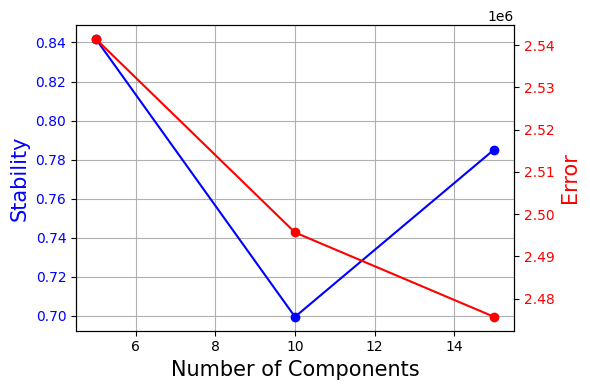

In [33]:
cnmf_obj.k_selection_plot()  

In [34]:
from tqdm.auto import tqdm

def run_cnmf_consensus(cnmf_obj=None, output_dir=None, name=None, 
                       components=[7,8,9,10], density_thresholds=[0.01, 0.05, 2.0]):

    if cnmf_obj is None:
        cnmf_obj = init_cnmf_obj(output_dir=output_dir, name=name)

    for k in tqdm(components, desc='Running cNMF'):
        for thresh in density_thresholds:
            cnmf_obj.consensus(k=k, density_threshold=thresh, show_clustering=True)
    

Running cNMF:   0%|          | 0/3 [00:00<?, ?it/s]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  33%|███▎      | 1/3 [00:06<00:13,  6.81s/it]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  67%|██████▋   | 2/3 [00:13<00:06,  7.00s/it]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF: 100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


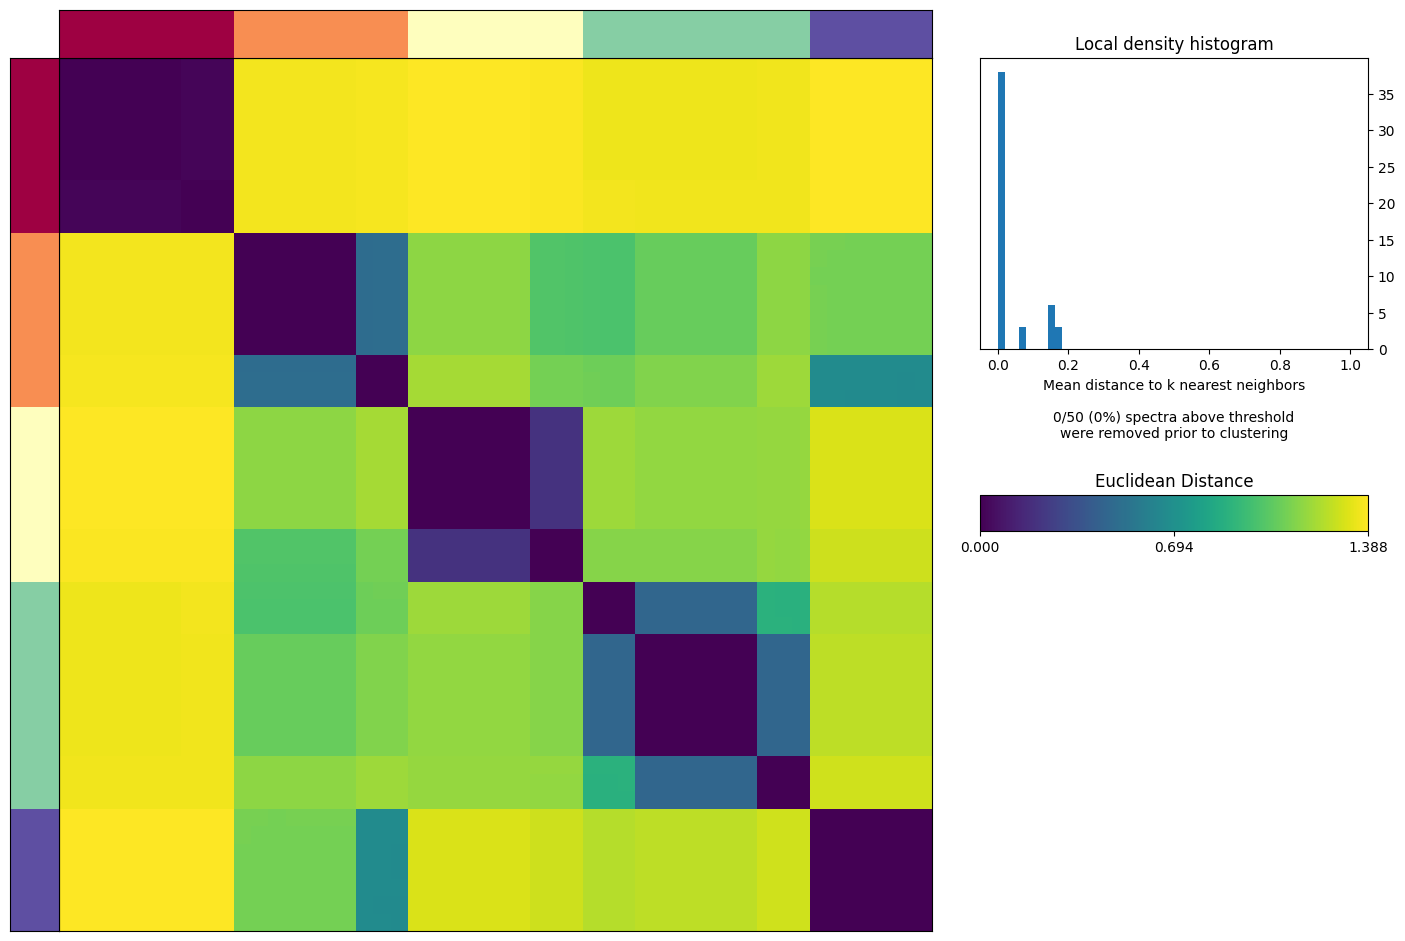

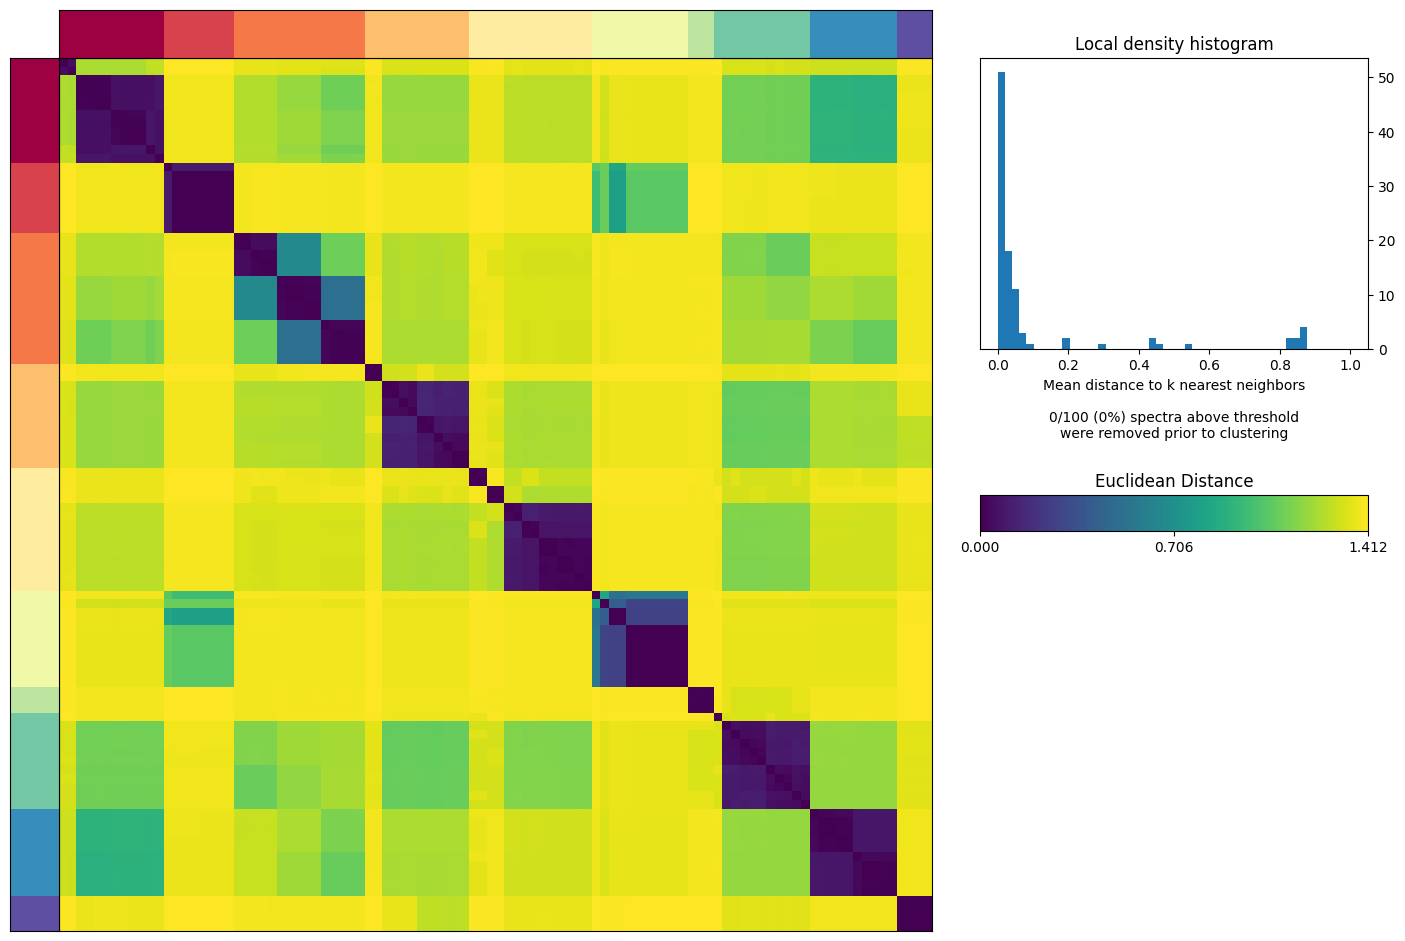

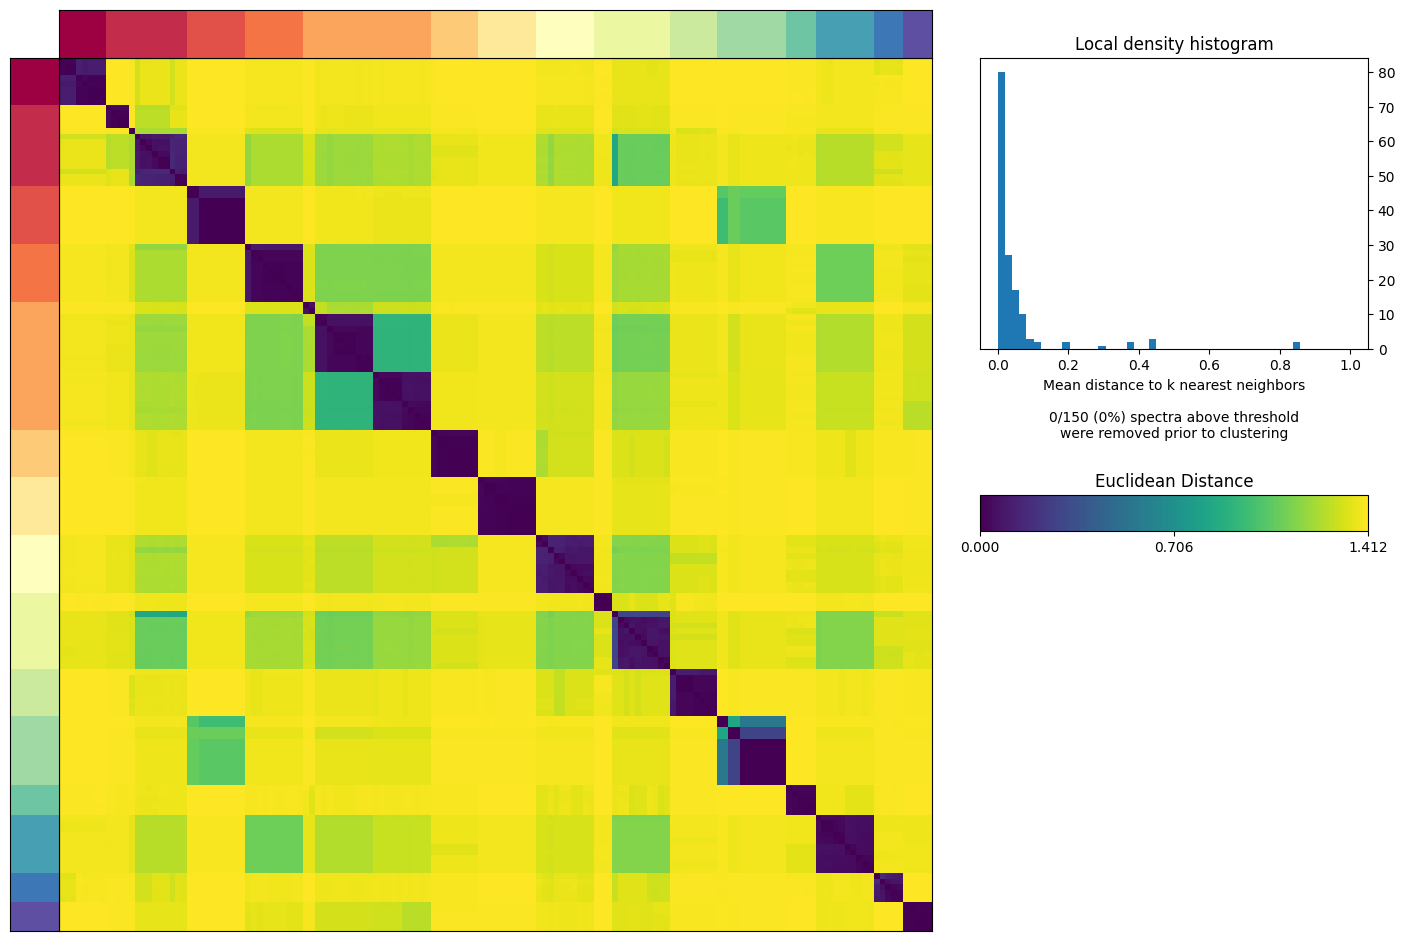

In [35]:
# Consensus plots with all k to choose thresh

run_cnmf_consensus(cnmf_obj, 
                   components=K, 
                   density_thresholds=[sel_thresh])

In [6]:
# Save all cNMF scores in separate mudata objects

for k in K:

    scores = pd.read_csv('{output_directory}/{run_name}/{run_name}.usages.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)

    loadings = pd.read_csv('{output_directory}/{run_name}/{run_name}.spectra.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)
    

    os.makedirs((f'{output_directory}/{run_name}/loading'), exist_ok=True)


    scores.to_csv('{output_directory}/{run_name}/loading/cNMF_scores_{k}_{sel_thresh}.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')
    loadings.T.to_csv('{output_directory}/{run_name}/loading/cNMF_loadings_{k}_{sel_thresh}.txt'.format(     
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')

    adata_ = anndata.read_h5ad('{output_directory}/{run_name}/cnmf_tmp/{run_name}.tpm.h5ad'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k ))
    adata_.var_names_make_unique()
    adata_.obs_names_make_unique()

    prog_data = anndata.AnnData(X=scores.values, obs=adata_.obs)
    prog_data.varm['loadings'] = loadings.values
    prog_data.uns['var_names'] = loadings.columns.values


    # Make adata
    os.makedirs((f'{output_directory}/{run_name}/prog_data'), exist_ok=True)
    prog_data.write(f'{output_directory}/{run_name}/prog_data/NMF_{k}_{sel_thresh}.h5ad'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))

    # Make mdata
    mdata = muon.MuData({'rna': adata_, 'cNMF': prog_data})

    if "guide_names" in adata_.uns:
        mdata['cNMF'].uns["guide_names"] = adata_.uns["guide_names"]

    if "guide_targets" in adata_.uns:
        mdata['cNMF'].uns["guide_targets"] = adata_.uns["guide_targets"]

    if "guide_assignment" in adata_.obsm:
        mdata['cNMF'].obsm["guide_assignment"] = adata_.obsm["guide_assignment"]

    os.makedirs((f'{output_directory}/{run_name}/adata'), exist_ok=True)
    mdata.write(f'{output_directory}/{run_name}/adata/cNMF_{k}_{sel_thresh}.h5mu'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))
                                                                            

In [ ]:
def get_top_indices_fast(df, gene_num = 300):
 
    # Get column names
    col_names = df.columns.values
    
    # Use argsort to get indices of top 300 values per row
    # argsort sorts in ascending order, so we use [:, -300:] and reverse
    top_indices = np.argsort(df.values, axis=1)[:, -gene_num:][:, ::-1]
    
    # Map indices to column names
    top_col_names = col_names[top_indices]
    
    # Create result DataFrame
    result_df = pd.DataFrame(
        top_col_names,
        index=df.index,
        columns=[f'top_{i+1}' for i in range(gene_num)]
    )

    result_df.index = [f'Program_{i}' for i in range(1,len(result_df)+1)]
    
    return result_df

def annotate_genes_to_excel(df, output_file='gene_annotations.xlsx'):
    
    # Initialize MyGene
    mg = mygene.MyGeneInfo()
    
    # Dictionary to store results for each column
    all_annotations = {}
    
    # Process each column
    for row_idx in df.index:
        # Get unique genes from column (remove NaN)
        genes = df.loc[row_idx].dropna().unique().tolist()
        
        if len(genes) == 0:
            print(f"Column '{row_idx}': No genes found")
            continue
        
        print(f"Annotating column '{row_idx}': {len(genes)} genes...")
        
        # Query MyGene for annotations
        results = mg.querymany(
            genes, 
            scopes='symbol,alias,ensembl.gene',  # Multiple search scopes
            fields='symbol,name,entrezgene,summary,type_of_gene',
            species='human',
            returnall=True
        )
        
        # Process results
        annotation_list = []
        for query_gene, gene_info in zip(genes, results['out']):
            # Handle cases where gene is not found or multiple matches
            if 'notfound' in gene_info and gene_info['notfound']:
                annotation_list.append({
                    'Input_Gene': query_gene,
                    'Gene_Symbol': 'NOT FOUND',
                    'Gene_Name': 'NOT FOUND',
                    'Entrez_ID': '',
                    'Type': '',
                    'Summary': ''
                })
            else:
                annotation_list.append({
                    'Input_Gene': query_gene,
                    'Gene_Symbol': gene_info.get('symbol', query_gene),
                    'Gene_Name': gene_info.get('name', ''),
                    'Entrez_ID': gene_info.get('entrezgene', ''),
                    'Type': gene_info.get('type_of_gene', ''),
                    'Summary': gene_info.get('summary', '')
                })
        
        # Create DataFrame for this column
        all_annotations[row_idx] = pd.DataFrame(annotation_list)

    # Export to Excel with multiple sheets
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for row_idx, annotations_df in all_annotations.items():
            sheet_name = str(row_idx)
            # Truncate sheet name if too long (Excel limit is 31 chars)
            sheet_name = sheet_name[:31] if len(sheet_name) > 31 else sheet_name
            annotations_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    return all_annotations


In [ ]:
# annotation for k=5 

gene_program = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/PBMC3K_example/PBMC3K_example.spectra.k_5.dt_2_0.consensus.txt"
df = pd.read_csv(gene_program, sep="\t", index_col = 0)

gene_num = 300
overlap = get_top_indices_fast(df, gene_num=gene_num)
annotate_genes_to_excel(overlap)